<a href="https://colab.research.google.com/github/calibretaliation/DeepLearning20211/blob/main/siamese_net_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Shopee matching problem using Siamese-inspired approach

## Import

In [1]:
!git clone https://github.com/calibretaliation/DeepLearning20211.git

Cloning into 'DeepLearning20211'...
remote: Enumerating objects: 32772, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (306/306), done.
remote: Total 32772 (delta 181), reused 0 (delta 0), pack-reused 32466
Receiving objects: 100% (32772/32772), 1.69 GiB | 22.03 MiB/s, done.
Resolving deltas: 100% (239/239), done.
Checking out files: 100% (32430/32430), done.


In [2]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 34.8 MB/s 


In [3]:
#@title Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
import math
import random

import os
import pickle

import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications, layers, losses, optimizers, metrics, Model, callbacks
from tensorflow.keras.applications import resnet, mobilenet_v3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from keras import backend

import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import top_k_accuracy_score
import seaborn as sns

from pathlib import Path

# import tensorflow_docs as tfdocs
# import tensorflow_docs.modeling
# import tensorflow_docs.plots


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

## Load and preprocess datasets

In [4]:
#@title Load CSV

train_df = pd.read_csv('DeepLearning20211/data/train.csv')
train_img_dir = Path('DeepLearning20211/data/train_images')

In [5]:
# train_df = pd.concat([train_df.iloc[:100], train_df.iloc[:100]]).reset_index(drop=True)

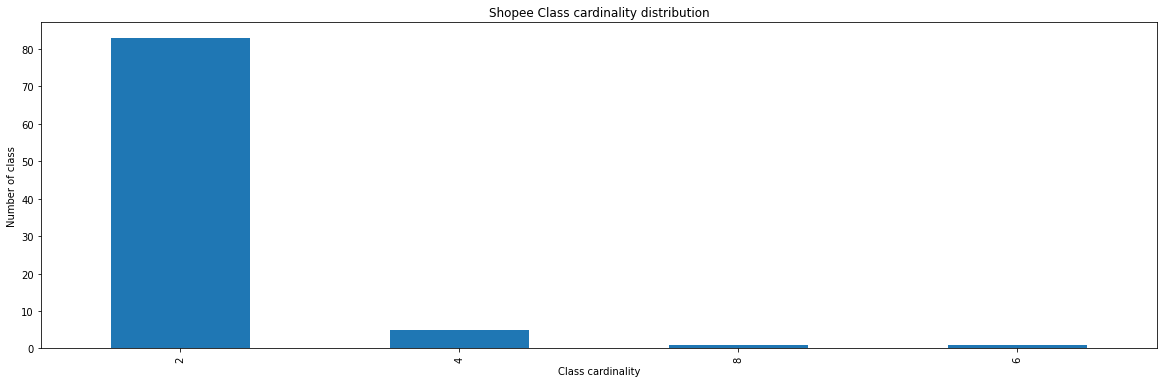

In [6]:
#@title Plot class cardinality distribution

# calculate number of images in each class
label_count = train_df['label_group'].value_counts()

plt.figure(figsize=(20, 6))
label_count.value_counts().plot.bar()
plt.xlabel('Class cardinality')
plt.ylabel('Number of class')
plt.title('Shopee Class cardinality distribution')
plt.show()

In [7]:
#@title Create validation set

train_df['index'] = train_df.index
val_df = train_df.sample(frac=1, random_state=14).groupby('label_group').nth(0)
val_df['label_group'] = val_df.index
val_df = val_df.set_index('index')
train_df = train_df.drop('index', axis=1)
train_df = train_df.drop(index=val_df.index).reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [8]:
# import shutil
# shutil.rmtree(str(temp_dir), ignore_errors=True)

In [9]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label_group'])

LabelEncoder()

In [10]:
batch_size = 64

data_augmentation = tf.keras.Sequential(
    [
     layers.RandomRotation(0.5),
     layers.RandomContrast(0.5),
     layers.RandomZoom((-0.2, 0.2)),
     layers.RandomTranslation(0.14, 0.14),
     ]
)

def filepath_to_img(filepath):
    img_string = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img_string)

    return img

def configure_dataset(ds, mode, fine_tune=False):
    assert mode == 'training' or mode == 'validation', "mode should be 'training' or 'validation'" 
    
    ds = ds.map(lambda filepath, label: (filepath_to_img(filepath), label), 
                num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.map(lambda img, label: (layers.Resizing(224, 224, crop_to_aspect_ratio=True)(img), label),
                num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.map(lambda img, label: (data_augmentation(img), label), 
                num_parallel_calls=tf.data.AUTOTUNE)
    
    if not fine_tune:               # we'll use some available preprocessing in keras model
        ds = ds.map(lambda img, label: (layers.Rescaling(1./255, offset=-1)(img), label),
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.prefetch(buffer_size=2048)
    ds = ds.batch(batch_size)
    
    return ds

## Define model and utilities

In [11]:
#@title Define embedding model (Run only once)

def get_embedding_model(first_trainable_layer=200):
    base_model = applications.MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3), include_top=False, include_preprocessing=True)

    output = layers.Flatten()(base_model.output)
    output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output)

    embedding = Model(base_model.input, output, name='Embedding')

    trainable = False
    for i in range(len(base_model.layers)):
        if i == first_trainable_layer:
            trainable = True
        base_model.layers[i].trainable = trainable

    return embedding

In [27]:
#@title Define custom callback

def get_summary_writer(name):
    log_dir = 'logs/' + name
    return {
        'train': tf.summary.create_file_writer(log_dir + '/train'),
        'val': tf.summary.create_file_writer(log_dir + '/val'),
        'lr': tf.summary.create_file_writer(log_dir + '/lr'),
        'best_weights': None,
        'epoch_loss' : [],
        'epoch_val_loss': []

    }

image_summary_writer = tf.summary.create_file_writer('logs/images')

class MyCallback(callbacks.Callback):
    def __init__(self, writers, reduce_lr=True, restore_best_weights=True):
        super(MyCallback, self).__init__()

        self.reduce_lr = reduce_lr
        self.restore_best_weights = restore_best_weights
        self.writers = writers

    def on_epoch_end(self, epoch, logs={}):

        with self.writers['lr'].as_default():
            tf.summary.scalar('learning rate', backend.get_value(self.model.optimizer.lr), step=len(self.writers['epoch_val_loss']))

        if self.reduce_lr and len(self.writers['epoch_loss']) > 0 and logs.get('loss') > self.writers['epoch_loss'][-1]:
            new_lr = backend.get_value(self.model.optimizer.lr) / 10.0
            backend.set_value(self.model.optimizer.lr, new_lr)
            print("\n[MyCallback]: Learning rate reduced to {}.".format(new_lr))

        if self.restore_best_weights and (len(self.writers['epoch_val_loss']) == 0 or logs.get('val_loss') < min(self.writers['epoch_val_loss']) - 1e-4):
            self.writers['best_weights'] = self.model.get_weights()
            print("\n[MyCallback]: Best weights on val_loss saved to 'best_weight'.")

        self.writers['epoch_loss'].append(logs.get('loss'))
        self.writers['epoch_val_loss'].append(logs.get('val_loss'))

        with self.writers['train'].as_default():
            tf.summary.scalar('loss', logs.get('loss'), step=len(self.writers['epoch_loss']) - 1)
        
        with self.writers['val'].as_default():
            tf.summary.scalar('loss', logs.get('val_loss'), step=len(self.writers['epoch_val_loss']) - 1)

In [14]:
def get_train_ds(train_df):
    train_df = train_df.sample(frac=1.0).reset_index(drop=True)
    train_ds = pd.concat([train_df, train_df]).sort_index(axis=0)
    train_ds = tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep + train_ds['image'], label_encoder.transform(train_ds['label_group'])))
    train_ds = configure_dataset(train_ds, mode='training', fine_tune=True)     # training using keras pretrained-model

    return train_ds

In [15]:
val_ds = pd.concat([val_df, val_df]).sort_index(axis=0)
val_labels = label_encoder.transform(val_ds['label_group'])
val_ds = tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep + val_ds['image'], val_labels))
val_ds = configure_dataset(val_ds, mode='validation', fine_tune=True)   # evaluation using keras pretrained-model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


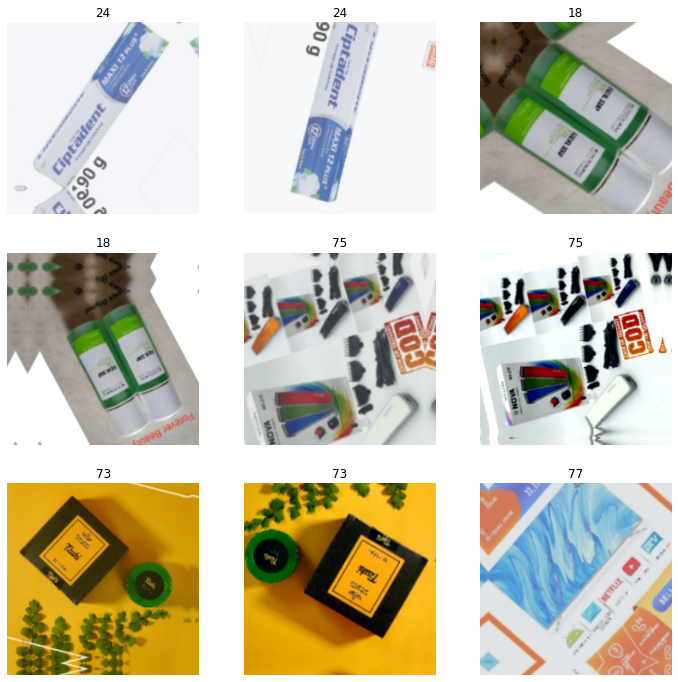

In [31]:
#@title Plot some training images
ncols = 3
nrows = 3
plt.figure(figsize=(4*ncols, 4*nrows))
spec = gridspec.GridSpec(ncols=ncols, nrows=nrows)
for img_batch, label_batch in get_train_ds(train_df).take(1):
    with image_summary_writer.as_default():
            tf.summary.image('training image', img_batch/255, max_outputs=64, step=0)
    i = 0
    for img, label in zip(img_batch, label_batch):
        plt.subplot(spec[i])
        plt.imshow(img/255)
        plt.title(label.numpy())
        plt.axis('off')

        i += 1
        if i == nrows * ncols:
            break
plt.show()

In [25]:
def train(embedding, num_epoch, writers):

    max_epoch = num_epoch + len(writers['epoch_loss'])
    for _ in range(num_epoch):
        train_ds = get_train_ds(train_df)

        print('Epoch %d/%d' % (len(writers['epoch_loss']) + 1, max_epoch))

        embedding.fit(
            train_ds,
            epochs=1,
            validation_data=val_ds,
            callbacks=[MyCallback(writers, reduce_lr=True, restore_best_weights=True)]
        )

## Train and evaluate model

In [28]:
semihard_embedding = get_embedding_model()
semihard_summary_writers = get_summary_writer('semihard')

semihard_embedding.compile(
    optimizer=SGD(learning_rate=5e-3, momentum=0.9, nesterov=True),
    loss=tfa.losses.TripletSemiHardLoss(),
    )

train(semihard_embedding, 2, semihard_summary_writers)

Epoch 1/2
4/4 [==============================] - ETA: 0s - loss: 0.7395
[MyCallback]: Best weights on val_loss saved to 'best_weight'.
4/4 [==============================] - 22s 4s/step - loss: 0.7395 - val_loss: 0.6762
Epoch 2/2
4/4 [==============================] - 17s 4s/step - loss: 0.7244 - val_loss: 0.6772


In [33]:
# embedding = semihard_embedding

In [34]:
#@title Create anchor embeddings

%%time

set_seed(42)
anchor_df = train_df.groupby('label_group').nth(0)

anchor_df['label_group'] = anchor_df.index
anchor_df = anchor_df.reset_index(drop=True)

num_per_anchor = 4

anchor_df = pd.concat([anchor_df for _ in range(num_per_anchor)]).sort_index(axis=0)
anchor_labels = label_encoder.transform(anchor_df['label_group'])
anchor_ds = tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep + anchor_df['image'], anchor_labels))
anchor_ds = configure_dataset(anchor_ds, mode='training', fine_tune=True)
anchor_embeddings = embedding.predict(anchor_ds)

pca = PCA(n_components=2)
decomposed_embeddings = pca.fit_transform(anchor_embeddings)

print('Anchor embeddings created')

Anchor embeddings created
CPU times: user 25.3 s, sys: 777 ms, total: 26.1 s
Wall time: 19.9 s


In [ ]:
with open('/content/drive/MyDrive/checkpoint/anchor_embeddings.pkl', 'wb') as f:
    pickle.dump(anchor_embeddings, f)

with open('/content/drive/MyDrive/checkpoint/anchor_labels.pkl', 'wb') as f:
    pickle.dump(anchor_labels, f)

In [35]:
#@title Use KNN for classification task

%%time
KNN = KNeighborsClassifier(n_neighbors=num_per_anchor)
KNN.fit(anchor_embeddings, anchor_labels)

CPU times: user 1.65 ms, sys: 0 ns, total: 1.65 ms
Wall time: 3.79 ms


In [36]:
#@title Calculate embeddings for validation set

%%time

val_embeddings = embedding.predict(val_ds)

CPU times: user 12 s, sys: 233 ms, total: 12.2 s
Wall time: 6.48 s


In [37]:
#@title Predict class probabilities for each validation image

%%time

val_preds = KNN.predict_proba(val_embeddings)

CPU times: user 20.7 ms, sys: 11 ms, total: 31.8 ms
Wall time: 24 ms


In [38]:
#@title Top-K accuracy

k = 5 #@param {type: "integer"}

top_k_accuracy_score(val_labels, val_preds, k=k)

1.0

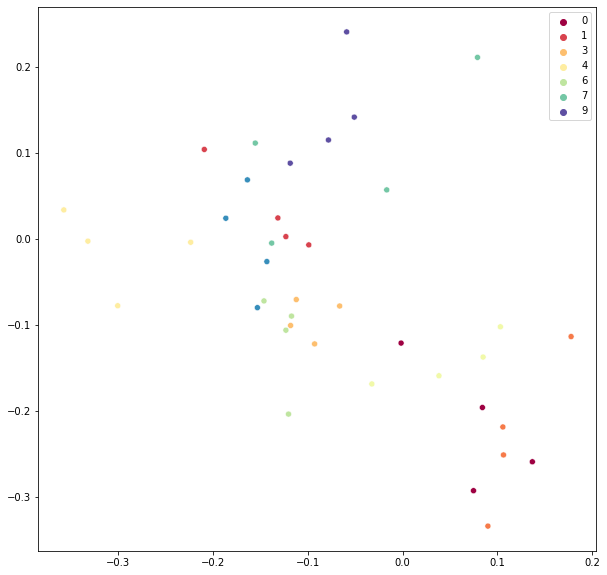

In [39]:
#@title Visualize anchor embeddings on 2D plane

num_class = 10 #@param {type: 'integer'}
plt.figure(figsize=(10, 10))
sns.scatterplot(x=decomposed_embeddings[:num_per_anchor * num_class, 0], 
                y=decomposed_embeddings[:num_per_anchor * num_class, 1], 
                hue=anchor_labels[:num_per_anchor * num_class], 
                palette=cm.get_cmap('Spectral')
)

In [ ]:
embedding.save('/content/drive/MyDrive/checkpoint/embedding')

In [ ]:
embedding = tf.keras.models.load_model('/content/drive/MyDrive/checkpoint/embedding')

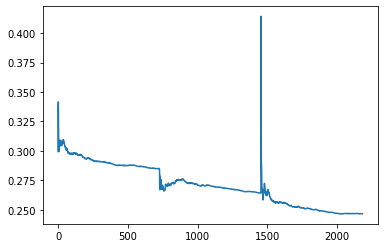

In [ ]:
all_losses = []
for _ in range(len(batch_loss_histories)): all_losses.extend(batch_loss_histories[_])
plt.plot(range(len(all_losses)), all_losses)
plt.show()

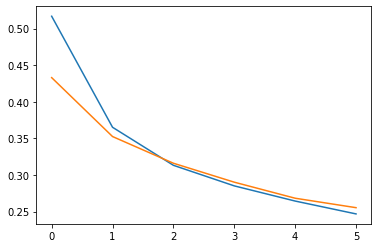

In [ ]:
max_epoch = len(epoch_loss_histories['loss'])
plt.plot(range(max_epoch), epoch_loss_histories['loss'], label='loss')
plt.plot(range(max_epoch), epoch_loss_histories['val_loss'], label='val_loss')
plt.show()

In [20]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/scalar

# Testing

In [ ]:
!tensorboard dev upload \
  --logdir logs/fit \
  --name "(optional) My latest experiment" \
  --description "(optional) Simple comparison of several hyperparameters" \
  --one_shot

In [ ]:
from tensorboard.plugins import projector



# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir='/logs/imdb-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for subwords in encoder.subwords:
    f.write("{}\n".format(subwords))
  # Fill in the rest of the labels with "unknown".
  for unknown in range(1, encoder.vocab_size - len(encoder.subwords)):
    f.write("unknown #{}\n".format(unknown))


# Save the weights we want to analyze as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, here
# we will remove this value.
weights = tf.Variable(model.layers[0].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
https://www.tensorflow.org/tensorboard/tensorboard_profiling_keras

In [ ]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Implements triplet loss."""

import tensorflow as tf
from tensorflow_addons.losses import metric_learning
from tensorflow_addons.utils.keras_utils import LossFunctionWrapper
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from typeguard import typechecked
from typing import Optional, Union, Callable


def _masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.

    Args:
      data: 2-D float `Tensor` of shape `[n, m]`.
      mask: 2-D Boolean `Tensor` of shape `[n, m]`.
      dim: The dimension over which to compute the maximum.

    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = tf.math.reduce_min(data, dim, keepdims=True)
    masked_maximums = (
        tf.math.reduce_max(
            tf.math.multiply(data - axis_minimums, mask), dim, keepdims=True
        )
        + axis_minimums
    )
    return masked_maximums


def _masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.

    Args:
      data: 2-D float `Tensor` of shape `[n, m]`.
      mask: 2-D Boolean `Tensor` of shape `[n, m]`.
      dim: The dimension over which to compute the minimum.

    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = tf.math.reduce_max(data, dim, keepdims=True)
    masked_minimums = (
        tf.math.reduce_min(
            tf.math.multiply(data - axis_maximums, mask), dim, keepdims=True
        )
        + axis_maximums
    )
    return masked_minimums


@tf.keras.utils.register_keras_serializable(package="Addons")
@tf.function
def triplet_semihard_loss(
    y_true: TensorLike,
    y_pred: TensorLike,
    margin: FloatTensorLike = 1.0,
    distance_metric: Union[str, Callable] = "L2",
) -> tf.Tensor:
    r"""Computes the triplet loss with semi-hard negative mining.

    Usage:

    >>> y_true = tf.convert_to_tensor([0, 0])
    >>> y_pred = tf.convert_to_tensor([[0.0, 1.0], [1.0, 0.0]])
    >>> tfa.losses.triplet_semihard_loss(y_true, y_pred, distance_metric="L2")
    <tf.Tensor: shape=(), dtype=float32, numpy=2.4142137>

    >>> # Calling with callable `distance_metric`
    >>> distance_metric = lambda x: tf.linalg.matmul(x, x, transpose_b=True)
    >>> tfa.losses.triplet_semihard_loss(y_true, y_pred, distance_metric=distance_metric)
    <tf.Tensor: shape=(), dtype=float32, numpy=1.0>

    Args:
      y_true: 1-D integer `Tensor` with shape `[batch_size]` of
        multiclass integer labels.
      y_pred: 2-D float `Tensor` of embedding vectors. Embeddings should
        be l2 normalized.
      margin: Float, margin term in the loss definition.
      distance_metric: `str` or a `Callable` that determines distance metric.
        Valid strings are "L2" for l2-norm distance,
        "squared-L2" for squared l2-norm distance,
        and "angular" for cosine similarity.

        A `Callable` should take a batch of embeddings as input and
        return the pairwise distance matrix.

    Returns:
      triplet_loss: float scalar with dtype of `y_pred`.
    """
    labels = tf.convert_to_tensor(y_true, name="labels")
    embeddings = tf.convert_to_tensor(y_pred, name="embeddings")

    convert_to_float32 = (
        embeddings.dtype == tf.dtypes.float16 or embeddings.dtype == tf.dtypes.bfloat16
    )
    precise_embeddings = (
        tf.cast(embeddings, tf.dtypes.float32) if convert_to_float32 else embeddings
    )

    # Reshape label tensor to [batch_size, 1].
    lshape = tf.shape(labels)
    labels = tf.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix

    if distance_metric == "L2":
        pdist_matrix = metric_learning.pairwise_distance(
            precise_embeddings, squared=False
        )

    elif distance_metric == "squared-L2":
        pdist_matrix = metric_learning.pairwise_distance(
            precise_embeddings, squared=True
        )

    elif distance_metric == "angular":
        pdist_matrix = metric_learning.angular_distance(precise_embeddings)

    else:
        pdist_matrix = distance_metric(precise_embeddings)

    # Build pairwise binary adjacency matrix.
    adjacency = tf.math.equal(labels, tf.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = tf.math.logical_not(adjacency)

    batch_size = tf.size(labels)

    # Compute the mask.
    pdist_matrix_tile = tf.tile(pdist_matrix, [batch_size, 1])
    mask = tf.math.logical_and(
        tf.tile(adjacency_not, [batch_size, 1]),
        tf.math.greater(
            pdist_matrix_tile, tf.reshape(tf.transpose(pdist_matrix), [-1, 1])
        ),
    )
    mask_final = tf.reshape(
        tf.math.greater(
            tf.math.reduce_sum(
                tf.cast(mask, dtype=tf.dtypes.float32), 1, keepdims=True
            ),
            0.0,
        ),
        [batch_size, batch_size],
    )
    mask_final = tf.transpose(mask_final)

    adjacency_not = tf.cast(adjacency_not, dtype=tf.dtypes.float32)
    mask = tf.cast(mask, dtype=tf.dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = tf.reshape(
        _masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size]
    )
    negatives_outside = tf.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = tf.tile(
        _masked_maximum(pdist_matrix, adjacency_not), [1, batch_size]
    )
    semi_hard_negatives = tf.where(mask_final, negatives_outside, negatives_inside)

    loss_mat = tf.math.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = tf.cast(adjacency, dtype=tf.dtypes.float32) - tf.linalg.diag(
        tf.ones([batch_size])
    )

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = tf.math.reduce_sum(mask_positives)

    triplet_loss = tf.math.truediv(
        tf.math.reduce_sum(
            tf.math.maximum(tf.math.multiply(loss_mat, mask_positives), 0.0)
        ),
        num_positives,
    )

    if convert_to_float32:
        return tf.cast(triplet_loss, embeddings.dtype)
    else:
        return triplet_loss


@tf.keras.utils.register_keras_serializable(package="Addons")
@tf.function
def triplet_hard_loss(
    y_true: TensorLike,
    y_pred: TensorLike,
    margin: FloatTensorLike = 1.0,
    soft: bool = False,
    distance_metric: Union[str, Callable] = "L2",
) -> tf.Tensor:
    r"""Computes the triplet loss with hard negative and hard positive mining.

    Usage:

    >>> y_true = tf.convert_to_tensor([0, 0])
    >>> y_pred = tf.convert_to_tensor([[0.0, 1.0], [1.0, 0.0]])
    >>> tfa.losses.triplet_hard_loss(y_true, y_pred, distance_metric="L2")
    <tf.Tensor: shape=(), dtype=float32, numpy=1.0>

    >>> # Calling with callable `distance_metric`
    >>> distance_metric = lambda x: tf.linalg.matmul(x, x, transpose_b=True)
    >>> tfa.losses.triplet_hard_loss(y_true, y_pred, distance_metric=distance_metric)
    <tf.Tensor: shape=(), dtype=float32, numpy=0.0>

    Args:
      y_true: 1-D integer `Tensor` with shape `[batch_size]` of
        multiclass integer labels.
      y_pred: 2-D float `Tensor` of embedding vectors. Embeddings should
        be l2 normalized.
      margin: Float, margin term in the loss definition.
      soft: Boolean, if set, use the soft margin version.
      distance_metric: `str` or a `Callable` that determines distance metric.
        Valid strings are "L2" for l2-norm distance,
        "squared-L2" for squared l2-norm distance,
        and "angular" for cosine similarity.

        A `Callable` should take a batch of embeddings as input and
        return the pairwise distance matrix.

    Returns:
      triplet_loss: float scalar with dtype of `y_pred`.
    """
    labels = tf.convert_to_tensor(y_true, name="labels")
    embeddings = tf.convert_to_tensor(y_pred, name="embeddings")

    convert_to_float32 = (
        embeddings.dtype == tf.dtypes.float16 or embeddings.dtype == tf.dtypes.bfloat16
    )
    precise_embeddings = (
        tf.cast(embeddings, tf.dtypes.float32) if convert_to_float32 else embeddings
    )

    # Reshape label tensor to [batch_size, 1].
    lshape = tf.shape(labels)
    labels = tf.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    if distance_metric == "L2":
        pdist_matrix = metric_learning.pairwise_distance(
            precise_embeddings, squared=False
        )

    elif distance_metric == "squared-L2":
        pdist_matrix = metric_learning.pairwise_distance(
            precise_embeddings, squared=True
        )

    elif distance_metric == "angular":
        pdist_matrix = metric_learning.angular_distance(precise_embeddings)

    else:
        pdist_matrix = distance_metric(precise_embeddings)

    # Build pairwise binary adjacency matrix.
    adjacency = tf.math.equal(labels, tf.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = tf.math.logical_not(adjacency)

    adjacency_not = tf.cast(adjacency_not, dtype=tf.dtypes.float32)
    # hard negatives: smallest D_an.
    hard_negatives = _masked_minimum(pdist_matrix, adjacency_not)

    batch_size = tf.size(labels)

    adjacency = tf.cast(adjacency, dtype=tf.dtypes.float32)

    mask_positives = tf.cast(adjacency, dtype=tf.dtypes.float32) - tf.linalg.diag(
        tf.ones([batch_size])
    )

    # hard positives: largest D_ap.
    hard_positives = _masked_maximum(pdist_matrix, mask_positives)

    if soft:
        triplet_loss = tf.math.log1p(tf.math.exp(hard_positives - hard_negatives))
    else:
        triplet_loss = tf.maximum(hard_positives - hard_negatives + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    if convert_to_float32:
        return tf.cast(triplet_loss, embeddings.dtype)
    else:
        return triplet_loss


@tf.keras.utils.register_keras_serializable(package="Addons")
class TripletSemiHardLoss(LossFunctionWrapper):
    """Computes the triplet loss with semi-hard negative mining.

    The loss encourages the positive distances (between a pair of embeddings
    with the same labels) to be smaller than the minimum negative distance
    among which are at least greater than the positive distance plus the
    margin constant (called semi-hard negative) in the mini-batch.
    If no such negative exists, uses the largest negative distance instead.
    See: https://arxiv.org/abs/1503.03832.

    We expect labels `y_true` to be provided as 1-D integer `Tensor` with shape
    `[batch_size]` of multi-class integer labels. And embeddings `y_pred` must be
    2-D float `Tensor` of l2 normalized embedding vectors.

    Args:
      margin: Float, margin term in the loss definition. Default value is 1.0.
      name: Optional name for the op.
    """

    @typechecked
    def __init__(
        self,
        margin: FloatTensorLike = 1.0,
        distance_metric: Union[str, Callable] = "L2",
        name: Optional[str] = None,
        **kwargs,
    ):
        super().__init__(
            triplet_semihard_loss,
            name=name,
            reduction=tf.keras.losses.Reduction.NONE,
            margin=margin,
            distance_metric=distance_metric,
        )


@tf.keras.utils.register_keras_serializable(package="Addons")
class TripletHardLoss(LossFunctionWrapper):
    """Computes the triplet loss with hard negative and hard positive mining.

    The loss encourages the maximum positive distance (between a pair of embeddings
    with the same labels) to be smaller than the minimum negative distance plus the
    margin constant in the mini-batch.
    The loss selects the hardest positive and the hardest negative samples
    within the batch when forming the triplets for computing the loss.
    See: https://arxiv.org/pdf/1703.07737.

    We expect labels `y_true` to be provided as 1-D integer `Tensor` with shape
    `[batch_size]` of multi-class integer labels. And embeddings `y_pred` must be
    2-D float `Tensor` of l2 normalized embedding vectors.

    Args:
      margin: Float, margin term in the loss definition. Default value is 1.0.
      soft: Boolean, if set, use the soft margin version. Default value is False.
      name: Optional name for the op.
    """

    @typechecked
    def __init__(
        self,
        margin: FloatTensorLike = 1.0,
        soft: bool = False,
        distance_metric: Union[str, Callable] = "L2",
        name: Optional[str] = None,
        **kwargs,
    ):
        super().__init__(
            triplet_hard_loss,
            name=name,
            reduction=tf.keras.losses.Reduction.NONE,
            margin=margin,
            soft=soft,
            distance_metric=distance_metric,
        )

In [52]:
import csv

with open('logs/feature_vecs.tsv', 'w') as fw:
    csv_writer = csv.writer(fw, delimiter='\t')
    csv_writer.writerows(anchor_embeddings)

with open('logs/metadata.tsv', 'w') as f:
    for label in anchor_labels:
        f.write(f'{label}\n')

In [ ]:
%tensorboard --logdir logs